The following code finds the transit times in a two planet system. The transit times of the inner planet are not exactly periodic, due to planet-planet interactions.

First, let's import the REBOUND and numpy packages.



In [101]:
import rebound
import numpy as np

Let's set up a coplanar two planet system.



In [121]:
sim = rebound.Simulation()
sim.dt = 0.01  # Set the time step to 0.01 (in simulation units)
sim.add(m=1)
sim.add(m=1e-6, a=1., e=0., inc=0.1, Omega=0.3, omega=0.1)
#sim.add(m=1e-5, a=1.757, e=0., inc=0.1, Omega=0.3, omega=0.5)
sim.move_to_com()

In [122]:
sim.particles[1].omega

3.167509694134686

We're now going to integrate the system forward in time. We assume the observer of the system is in the direction of the positive x-axis. We want to measure the time when the inner planet transits. In this geometry, this happens when the y coordinate of the planet changes sign. Whenever we detect a change in sign between two steps, we try to find the transit time, which must lie somewhere within the last step, by bisection.

In [90]:
N=174
transittimes = np.zeros(N)
p = sim.particles
i = 0
thetas = []
a_s = []
while i<N:
    thetas.append(p[1].e)
    a_s.append(p[1].a)
    
    y_old = p[1].y - p[0].y  # (Thanks to David Martin for pointing out a bug in this line!)
    t_old = sim.t
    sim.integrate(sim.t+0.5) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
    t_new = sim.t
    if y_old*(p[1].y-p[0].y)<0. and p[1].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
        while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
            if y_old*(p[1].y-p[0].y)<0.:
                t_new = sim.t
            else:
                t_old = sim.t
            sim.integrate( (t_new+t_old)/2.)
        transittimes[i] = sim.t
        i += 1
        sim.integrate(sim.t+0.05)       # integrate 0.05 to be past the transit


In [91]:
print(len(transittimes))
print(p[1].P)

174
6.28308052825583


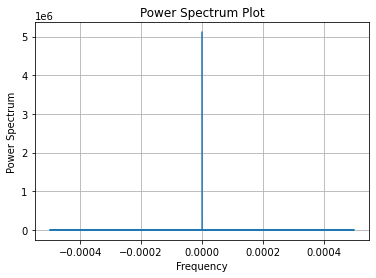

[ 0.00000000e+00  4.42282176e-07  8.84564352e-07 ... -1.32684653e-06
 -8.84564352e-07 -4.42282176e-07]
0.0
Period: inf


/var/folders/9z/bcj7jltn3x5_8y20r9cxql3h0000gn/T/ipykernel_31582/402249758.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  period = 1 / dominant_frequency


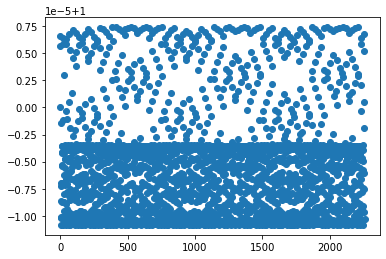

In [100]:
import numpy as np
from scipy.fft import fft, fftfreq

fft_result = fft(a_s)

power_spectrum = np.abs(fft_result) ** 2


sampling_frequency = .001
frequencies = fftfreq(len(a_s), d=1/sampling_frequency)

# Step 6: Plot the power spectrum
plt.plot(frequencies, power_spectrum)
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.title('Power Spectrum Plot')
plt.grid(True)
plt.show()

print(frequencies)

dominant_frequency_index = np.argmax(power_spectrum)
dominant_frequency = frequencies[dominant_frequency_index]
print(dominant_frequency)

# Step 7: Compute the period
period = 1 / dominant_frequency

print("Period:", period)


plt.scatter(range(len(a_s)), a_s)

Next, we do a linear least square fit to remove the linear trend from the transit times, thus leaving us with the transit time variations.

In [7]:
A = np.vstack([np.ones(N), range(N)]).T
c, m = np.linalg.lstsq(A, transittimes, rcond=-1)[0]


Finally, let us plot the TTVs.



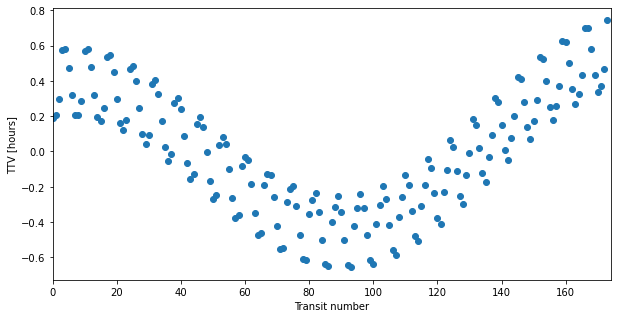

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(111)
ax.set_xlim([0,N])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")
plt.scatter(range(N), (transittimes-m*np.array(range(N))-c)*(24.*365./2./np.pi));
plt.sca

## Orbital Elements

Note: All angles for orbital elements are in radians

We can add particles to a simulation by specifying cartesian components:

In [38]:
import rebound
sim = rebound.Simulation()
sim.add(m=1., x=1., vz = 2.)

Any components not passed automatically default to 0. REBOUND can also accept orbital elements.

Reference bodies

As a reminder, there is a one-to-one mapping between (x,y,z,vx,vy,vz) and orbital elements, and one should always specify what the orbital elements are referenced against (e.g., the central star, the system's barycenter, etc.). The differences between orbital elements referenced to these centers differ by ∼ the mass ratio of the largest body to the central mass. By default, REBOUND always uses Jacobi elements, which for each particle are always referenced to the center of mass of all particles with lower index in the simulation.

For the painstaking user: When separating out the center of mass degree of freedom and reducing the N body problem to N-1 Kepler problems and interaction terms, there are a number of possible Hamiltonian splittings (see e.g., Hernandez & Dehnen 2017), and different possible choices for the primary mass in each of the separate Kepler problems. REBOUND takes this primary mass to be the total mass of all the particles in the simulation. If particles are added from the inside out, this gives logical behavior in the limit of a hierarchical system, even for large masses (one can think of it as setting up our new particle in a 2-body orbit around all the interior mass concentrated at the interior particles' center of mass).



In [39]:
sim.status()

---------------------------------
REBOUND version:     	3.26.0
REBOUND built on:    	Jul 19 2023 09:21:29
Number of particles: 	1
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.particle.Particle object at 0x7fab08f9f840, m=1.0 x=1.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=2.0>
---------------------------------


We always have to pass a semimajor axis (to set a length scale), but any other elements are by default set to 0. Now we could add a distant planet on a circular orbit,

In [40]:
sim.add(m=1.e-3, a=100.)
sim.status()

---------------------------------
REBOUND version:     	3.26.0
REBOUND built on:    	Jul 19 2023 09:21:29
Number of particles: 	2
Selected integrator: 	ias15
Simulation time:     	0.0000000000000000e+00
Current timestep:    	0.001000
---------------------------------
<rebound.particle.Particle object at 0x7fab08f9f940, m=1.0 x=1.0 y=0.0 z=0.0 vx=0.0 vy=0.0 vz=2.0>
<rebound.particle.Particle object at 0x7fab08f9fbc0, m=0.001 x=101.0 y=0.0 z=0.0 vx=0.0 vy=0.1000499875062461 vz=2.0>
---------------------------------


This planet is set up relative to the stellar center of mass (due to the Jacobi coordinates) with vz = 2 as well

All simulations are performed in Cartesian elements, so to avoid the overhead, REBOUND does not update particles' orbital elements as the simulation progresses. However, you can always access any orbital element through, e.g., sim.particles[1].inc (see the diagram, and table of orbital elements under the Orbit structure at httsp://rebound.readthedocs.org/en/latest/python_api.html). This will calculate that orbital element individually--you can calculate all the particles' orbital elements at once with sim.calculate_orbits(). REBOUND will always output angles in the range [-π, π], except the inclination which is always in [0, π].

In [41]:
print(sim.particles[1].a)
orbits = sim.calculate_orbits()
for orbit in orbits:
    print(orbit)

100.00000000000003
<rebound.Orbit instance, a=100.00000000000003 e=1.732990485491316e-16 inc=0.0 Omega=0.0 omega=0.0 f=0.0>


Notice that there is always one less orbit than there are particles, since orbits are only defined between pairs of particles. 

To get orbital elements relative to a specific body, you can manually use the calculate_orbit method of the Particle class:


....for example, lets get the orbit of the star relative to the planet


In [45]:
print(sim.particles[0].calculate_orbit(primary=sim.particles[1]))


<rebound.Orbit instance, a=100.00000000000003 e=1.732990485491316e-16 inc=0.0 Omega=0.0 omega=3.141592653589793 f=0.0>




When you access orbital elements individually, e.g., sim.particles[1].inc, you always get Jacobi elements. If you need to specify the primary, you have to do it with sim.calculate_orbit() as above.

#### Edge cases and orbital element sets

Different orbital elements lose meaning in various limits, e.g., a planar orbit and a circular orbit. REBOUND therefore allows initialization with several different types of variables that are appropriate in different cases. It's important to keep in mind that the procedure to initialize particles from orbital elements is not exactly invertible, so one can expect discrepant results for elements that become ill-defined. For example,

In [123]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1., e=0., inc=0.1, Omega=0.3, omega=0.1)
print(sim.particles[1].orbit)

<rebound.Orbit instance, a=0.9999999999999991 e=5.552131893060635e-16 inc=0.09999999999999945 Omega=0.29999999999999977 omega=3.2607309416278603 f=3.122454365551725>



The problem here is that 
ω (the angle from the ascending node to pericenter) is ill-defined for a circular orbit, so it's not clear what we mean when we pass it, and we get spurious results for both ω and f, since the latter is also undefined as the angle from pericenter to the particle's position. However, the true longitude θ, the broken angle from the x axis to the ascending node = Ω + ω + f, and then to the particle's position, is always well-defined:

In [124]:
print(sim.particles[1].e)


5.552131893060635e-16


To be clearer and ensure we get the results we expect, we could instead pass theta to specify the longitude we want, e.g.



In [48]:
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1., e=0., inc=0.1, Omega=0.3, theta = 0.4)
print(sim.particles[1].theta)

0.3999999999999986


In [21]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1., e=0.2, Omega=0.1)
print(sim.particles[1].orbit)

<rebound.Orbit instance, a=0.9999999999999998 e=0.19999999999999982 inc=0.0 Omega=0.0 omega=0.09999999999999964 f=8.881784197001252e-16>


Here we have a planar orbit, in which case the line of nodes becomes ill-defined, so Ω is not a good variable, but we pass it anyway! In this case, ω is also undefined since it is referenced to the ascending node. Here we get that now these two ill-defined variables get flipped. The appropriate variable is pomega (ϖ = Ω + ω), which is the angle from the x axis to pericenter:

In [22]:
print(sim.particles[1].pomega)


0.09999999999999945


We can specify the pericenter of the orbit with either ω or ϖ:

In [24]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1., e=0.2, pomega=0.1)
print(sim.particles[1].orbit)

<rebound.Orbit instance, a=0.9999999999999998 e=0.19999999999999982 inc=0.0 Omega=0.0 omega=0.09999999999999964 f=8.881784197001252e-16>



Note that if the inclination is exactly zero, REBOUND sets 
Ω (which is undefined) to 0, so ω = ϖ.

Finally, we can specify the position of the particle along its orbit using mean (rather than true) longitudes or anomalies (for example, this might be useful for resonances). We can either use the mean anomaly, M, which is referenced to pericenter (again ill-defined for circular orbits), or its better-defined counterpart the mean longitude l = λ = Ω + ω + M, which is analogous to θ above,

In [25]:

sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1., e=0.1, Omega=0.3, M = 0.1)
sim.add(a=1., Omega=0.3, l = 0.4)
print(sim.particles[1].l)
print(sim.particles[2].l)

0.4000000000000039
0.39999999999999947


REBOUND calculates the mean longitude in such a way that it smoothly approaches θ in the limit of e→0:

In [26]:
sim.particles[2].theta


0.39999999999999947

In [27]:
import rebound
sim = rebound.Simulation()
sim.add(m=1.)
sim.add(a=1., e=0.1, omega=1.)
print(sim.particles[1].orbit)

<rebound.Orbit instance, a=1.0000000000000002 e=0.10000000000000024 inc=0.0 Omega=0.0 omega=1.0 f=0.0>


In summary, you can specify the phase of the orbit through any one of the angles M, f, theta or l= λ. Additionally, one can instead use the time of pericenter passage T. This time should be set in the appropriate time units, and you'd initialize sim.t to the appropriate time you want to start the simulation.

#### Accuracy

As a test of accuracy and demonstration of issues related to the last section, let's test the numerical stability by initializing particles with small eccentricities and true anomalies, computing their orbital elements back, and comparing the relative error. We choose the inclination and node longitude randomly:

In [28]:
import random
import numpy as np

def simulation(par):
    e,f = par
    e = 10**e
    f = 10**f
    sim = rebound.Simulation()
    sim.add(m=1.)
    a = 1.
    inc = random.random()*np.pi
    Omega = random.random()*2*np.pi
    sim.add(m=0.,a=a,e=e,inc=inc,Omega=Omega, f=f)
    o=sim.particles[1].orbit
    if o.f < 0: # avoid wrapping issues
        o.f += 2*np.pi
    err = max(np.fabs(o.e-e)/e, np.fabs(o.f-f)/f)
    return err

random.seed(1)
N = 100
es = np.linspace(-16.,-1.,N)
fs = np.linspace(-16.,-1.,N)
params = [(e,f) for e in es for f in fs]

pool=rebound.InterruptiblePool()
res = pool.map(simulation, params)
res = np.array(res).reshape(N,N)
res = np.nan_to_num(res)

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.colors import LogNorm
import matplotlib

f,ax = plt.subplots(1,1,figsize=(7,5))
extent=[fs.min(), fs.max(), es.min(), es.max()]

ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_xlabel(r"true anomaly (f)")
ax.set_ylabel(r"eccentricity")

im = ax.imshow(res, norm=LogNorm(vmax=1., vmin=1.e-16), aspect='auto', origin="lower", interpolation='nearest', cmap="RdYlGn_r", extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.solids.set_rasterized(True)
cb.set_label("Relative Error")

Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'simulation' on <module '__main__' (built-in)>
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/daniel/opt/a

Process SpawnPoolWorker-16:
Traceback (most recent call last):
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'simulation' on <module '__main__' (built-in)>
Process SpawnPoolWorker-18:
Process SpawnPoolWorker-17:
Traceback (most recent call last):
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwarg

Process SpawnPoolWorker-30:
Traceback (most recent call last):
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/queues.py", line 368, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'simulation' on <module '__main__' (built-in)>
Process SpawnPoolWorker-28:
Traceback (most recent call last):
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/daniel/opt/anaconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/daniel/opt

KeyboardInterrupt: 

We see that the behavior is poor, which is physically due to f becoming poorly defined at low e. If instead we initialize the orbits with the true longitude θ as discussed above, we get much better results:

In [ ]:
def simulation(par):
    e,theta = par
    e = 10**e
    theta = 10**theta
    sim = rebound.Simulation()
    sim.add(m=1.)
    a = 1.
    inc = random.random()*np.pi
    Omega = random.random()*2*np.pi
    omega = random.random()*2*np.pi
    sim.add(m=0.,a=a,e=e,inc=inc,Omega=Omega, theta=theta)
    o=sim.particles[1].orbit
    if o.theta < 0:
        o.theta += 2*np.pi
    err = max(np.fabs(o.e-e)/e, np.fabs(o.theta-theta)/theta)
    return err

random.seed(1)
N = 100
es = np.linspace(-16.,-1.,N)
thetas = np.linspace(-16.,-1.,N)
params = [(e,theta) for e in es for theta in thetas]

pool=rebound.InterruptiblePool()
res = pool.map(simulation, params)
res = np.array(res).reshape(N,N)
res = np.nan_to_num(res)

f,ax = plt.subplots(1,1,figsize=(7,5))
extent=[thetas.min(), thetas.max(), es.min(), es.max()]

ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.set_xlabel(r"true longitude (\theta)")
ax.set_ylabel(r"eccentricity")

im = ax.imshow(res, norm=LogNorm(vmax=1., vmin=1.e-16), aspect='auto', origin="lower", interpolation='nearest', cmap="RdYlGn_r", extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.solids.set_rasterized(True)
cb.set_label("Relative Error")